In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp, DensityMatrix, Statevector, state_fidelity
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit import Parameter # To enable parameterized circuits
from qiskit.circuit.library import SwapGate
from qiskit_aer import AerSimulator

import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_bloch_vector
from math import pi, sqrt
from matplotlib import pyplot as plt

# 01 (Alice X Gate)

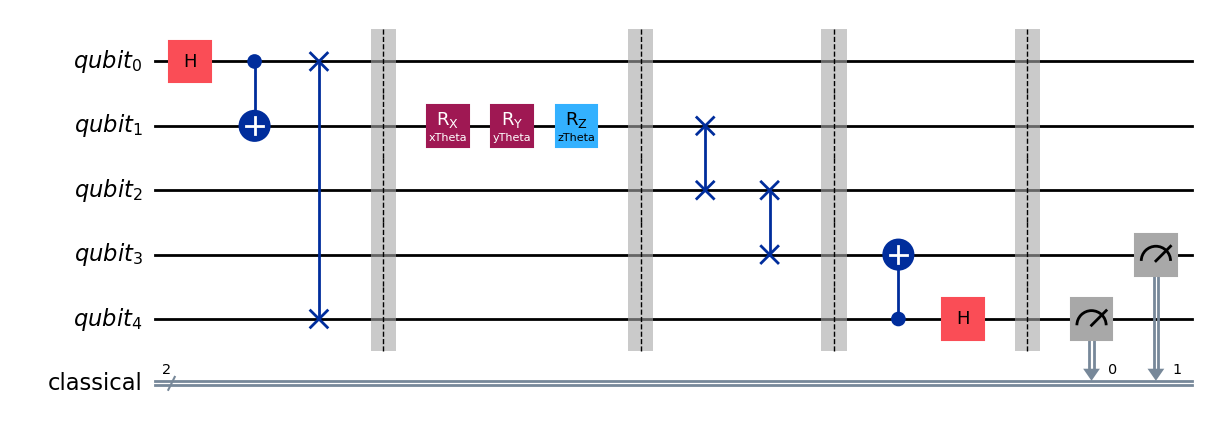

In [3]:
bNum = 2

xTheta = Parameter('xTheta')
yTheta = Parameter('yTheta')
zTheta = Parameter('zTheta')



num_data_qubits = bNum+3
num_data_cbits = 2

# Create qubit and classical data bit registers (you can create and name additional registers if it's useful for bookkeeping)
data_qubits = QuantumRegister(num_data_qubits, "qubit")
classical_data = ClassicalRegister(num_data_cbits, "classical")

# Create circuit object
qc = QuantumCircuit(data_qubits,  classical_data)

# Create empty lists to store qubits and classical bits for convenient access
qdata = []; cdata = []; 

# Store qubits from data_qubit register in list for convenient access
qdata[:] = data_qubits

# Store classical bits from classical_data register in list for convenient access
cdata[:] = classical_data
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.h(0) #This is state to be transported
qc.cx(0,1)
qc.swap(0,4)
qc.barrier()

# qc.id(1)
qc.rx(xTheta,1)
qc.ry(yTheta,1)
qc.rz(zTheta,1)
# qc.x(1)
# qc.z(1)
qc.barrier()

for i in range (1, bNum + 1):
    qc.swap(i, i+1)
qc.barrier()

qc.cx(bNum+2, bNum + 1)
qc.h(bNum+2)
qc.barrier()

qc.measure(bNum + 2, 0)
qc.measure(bNum + 1, 1)


qc.draw('mpl')

In [4]:

def send(bits2):
    params = {zTheta: 0,     yTheta: 0,     xTheta: 0}
    # if (bits2=='00'):
    #     params = {zTheta: 0,     yTheta: 0,     xTheta: 0}
    if (bits2=='10'):
        params = {zTheta: 0,     yTheta: 0,     xTheta: pi}
    if (bits2 == '01'):
        params = {zTheta: pi,     yTheta: 0, xTheta: 0}
    if (bits2=='11'):
        params = {zTheta: pi, yTheta: 0,     xTheta: pi}
    return params
def send_string(bits):
    param_sets = []
    if (len(bits)%2==1):
        bits=f"{bits}0"
    for i in range(0,len(bits),2):
        bits2 = bits[i:i+2]
        param_sets.append(send(bits2))
    return param_sets



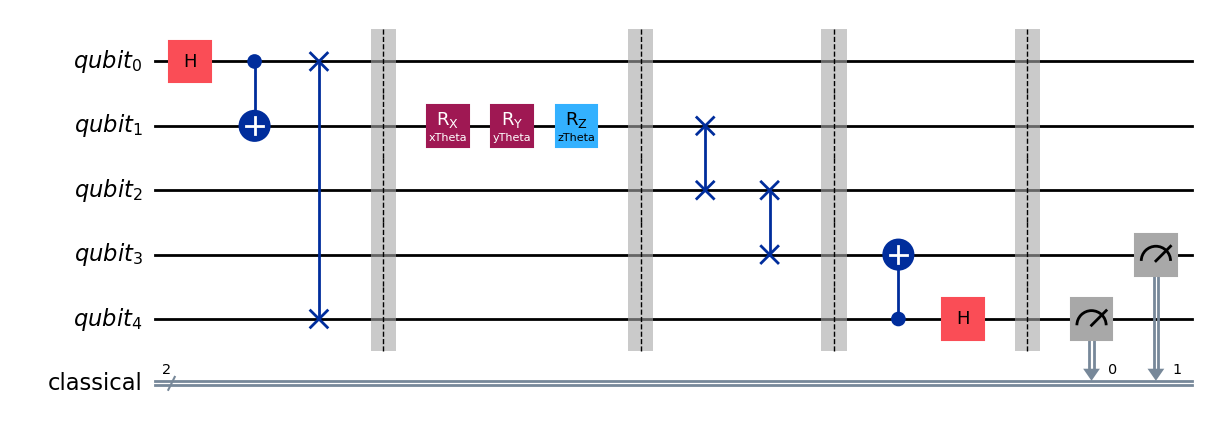

In [5]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_aer import AerSimulator
#backend = FakeSherbrooke()
backend = AerSimulator()
sampler = Sampler(backend)

# Create the "pass manager" that will perform the transpilation
pm = generate_preset_pass_manager(backend=backend, optimization_level=0)

# Run the pass manager to generate the transpiled circuit
transpiled_circuit = pm.run(qc)
transpiled_circuit.draw('mpl')

In [6]:
param_sets = send_string("01101110010001010010")
bound_circuits = [transpiled_circuit.assign_parameters(param) for param in param_sets]
job2 = sampler.run(bound_circuits, shots = 1)


In [7]:
def recieve_string(job):
    message = ""
    for i in range(len(job.result())):
        result = job.result()[i].data.classical.get_counts()
        max=0
        mess_seg = ""
        for res in result:
            if (result[res]>max):
                mess_seg = res
        message = f"{message}{mess_seg}"
        #print(job2.result()[i].data.classical.get_counts())
    return message
print(recieve_string(job2))

01101110010001010010


In [11]:
from PIL import Image
img = Image.open("C:\\Users\\caleb\\Downloads\\mountain.jpg")
pixels = list(img.getdata())
pixel_string =  ''.join(str(num) for tup in pixels for num in tup)


In [ ]:
param_sets = send_string(pixel_string)
bound_circuits = [transpiled_circuit.assign_parameters(param) for param in param_sets]
job2 = sampler.run(bound_circuits, shots=1)